In [31]:
%matplotlib inline
import numpy as np
import matplotlib
import os
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from colorsys import rgb_to_hls
from PIL import Image
from scipy.stats import stats
from sklearn.utils import shuffle
sns.set(font_scale=1.5, style="ticks", color_codes=True)
plt.rcParams['figure.figsize'] = (12, 9)

In [14]:
csv_file = "/home/dat/Workspace/Thesis/lettuce_predictor/data/rasters_csv/2017-11-22.csv"
biomass_file = "/home/dat/Workspace/Thesis/data/Spreadsheet/Lettuce/biomass.csv"

## Load data and calculate indices

In [43]:
def preprocess_spectra(df, base):
    df = average_dataframe(df, 15).transpose()
    nm = [str(int(x)) for x in df.iloc[0]]
    df = df.drop("Wavelengths", 0)
    df.columns = nm
    df = pd.concat([base, df], axis=1)
    return df

def average_dataframe(df, n):
    # Separate label column from data
    label = df.iloc[:,0]
    df = df.iloc[:,1:]

    if (df.shape[1]) % n != 0:
        raise Exception("Number of columns: {}. Not divisible by {}.".format(df.shape[1], n))

    # Average every N columns
    average_df = pd.DataFrame()
    average_df["Wavelengths"] = label
    for i in range((df.shape[1]) // n):
        average_df[i] = df.iloc[:,i*n:(i+1)*n].mean(axis=1)

    return average_df

In [44]:
df = pd.read_csv(csv_file)
df.describe()

,Nitrogen,Irrigation,Replication,Plant Number,Chlorophyll,NDVI,WP,Average Height,Average Leaf Count
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,48.000000,96.000000,96.000000
mean,43.750000,43.750000,2.000000,209.000000,39.958333,0.834818,-1.794375,22.791667,20.854167
std,37.169597,37.169597,0.820783,5.026247,4.825888,0.023022,1.473319,4.381580,2.627703
min,0.000000,0.000000,1.000000,204.000000,29.000000,0.765509,-4.860000,14.000000,14.000000
25%,18.750000,18.750000,1.000000,204.000000,36.800000,0.820132,-2.392500,20.000000,19.000000
50%,37.500000,37.500000,2.000000,209.000000,40.000000,0.838589,-1.190000,23.000000,21.000000
75%,62.500000,62.500000,3.000000,214.000000,42.625000,0.853642,-0.740000,25.000000,23.000000
max,100.000000,100.000000,3.000000,214.000000,51.400000,0.876963,-0.510000,35.000000,25.000000


In [54]:
base = pd.read_csv("../data/Spreadsheet/Lettuce/base.csv")
spectra = preprocess_spectra(pd.read_csv("../data/Unprocessed/2017-11-22.csv"), base)
spectra.head()

,Nitrogen,Irrigation,Replication,325,326,327,328,329,330,331,...,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075
0,100,100,1,0.313274,0.343379,0.320248,0.283593,0.243390,0.218948,0.222832,...,0.862408,0.856769,0.856842,0.862867,0.865294,0.866957,0.870656,0.866418,0.858703,0.856869
1,100,100,1,0.441978,0.486066,0.452517,0.392027,0.324680,0.315718,0.332866,...,0.802437,0.800025,0.801826,0.806253,0.806605,0.806869,0.810670,0.807999,0.801796,0.799255
2,25,100,2,0.426885,0.485064,0.452165,0.405516,0.361028,0.330148,0.333996,...,0.812972,0.810719,0.811991,0.815929,0.815246,0.815399,0.821031,0.817589,0.809409,0.807045
3,25,100,2,0.485814,0.512206,0.463127,0.401118,0.344746,0.348435,0.368000,...,0.855653,0.850706,0.851357,0.858719,0.857798,0.856709,0.863082,0.859316,0.850732,0.850005
4,0,100,3,0.478258,0.522028,0.489291,0.426278,0.357162,0.368271,0.406586,...,0.937615,0.931627,0.930801,0.936822,0.938160,0.938891,0.942972,0.938665,0.930765,0.929594


In [55]:
biomass = pd.read_csv(biomass_file)
df = df.merge(biomass, how="left", on=["Nitrogen", "Irrigation", "Replication"])
df = df.merge(spectra, how="left", on=["Nitrogen", "Irrigation", "Replication"])
df["WBI"] = df["970"] / df["900"]

In [56]:
EPSILON = 1e-10

def NDVI(R, NIR):
    return (NIR - R) / (NIR + R + EPSILON)

def RedEdge(R, RE):
    return RE / (R + EPSILON)

def EVI(B, R, NIR):
    return 2.5 * (NIR - R) / (NIR + EPSILON) + 6 * R - 7.5 * B + 1 

def MCARI(G, R, RE):
    return (RE - R) - 0.23 * (RE - G) * RE / (R + EPSILON)

def GNDVI(G, NIR):
    return (NIR - G) / (NIR + G + EPSILON)

def DGCI(H, L, S):
    return ((H - 60) / 60 + (1 - S) + (1 - L)) / 3

In [57]:
channel_vals = []
for id, row in df.iterrows():
    raster = np.load(row["img_path"])
    # Crop border to only get plant in image
    # raster = raster[1:-1, 1:-1]
    b, g, r, re, nir = np.mean(raster, axis=(0, 1))
    channel_vals.append([b, g, r, re, nir])
    
df["channel_vals"] = channel_vals

In [58]:
ndvi, rededge, evi, mcari, gndvi, dgci, channel_vals = [], [], [], [], [], [], []
for id, row in df.iterrows():
    raster = np.load(row["img_path"])
    b, g, r, re, nir = np.mean(raster, axis=(0, 1))
    ndvi.append(NDVI(r, nir))
    rededge.append(RedEdge(r, re))
    evi.append(EVI(b, r, nir))
    mcari.append(MCARI(g, r, re))
    gndvi.append(GNDVI(g, nir))
    # channel_vals.append([b, g, r, re, nir])
    channel_vals.append([b, g, r])
    hls = np.zeros((raster.shape[0], raster.shape[1], 3))
    for i in range(raster.shape[0]):
        for j in range(raster.shape[1]):
            hls[i, j] = rgb_to_hls(raster[i,j,2], raster[i,j,1], raster[i,j,0])
    h, l, s = np.mean(hls, axis=(0, 1))
    dgci.append(DGCI(h, l, s))
    
df["UAV_NDVI"] = ndvi
df["RedEdge"] = rededge
df["EVI"] = evi
df["MCARI"] = mcari
df["GNDVI"] = gndvi
df["DGCI"] = dgci
df["channel_vals"] = channel_vals

In [59]:
df.head()

,Nitrogen,Irrigation,Replication,Plant Number,Chlorophyll,NDVI,WP,Average Height,Average Leaf Count,img_path,...,1067,1068,1069,1070,1071,1072,1073,1074,1075,WBI
0,0,0,1,204,36.9,0.816948,-4.86,16,18,/home/dat/Workspace/Thesis/lettuce_predictor/d...,...,0.883832,0.884929,0.885821,0.883979,0.881663,0.881186,0.880948,0.881121,0.882271,0.951567
1,0,0,1,204,36.9,0.816948,-4.86,16,18,/home/dat/Workspace/Thesis/lettuce_predictor/d...,...,0.821819,0.823155,0.827375,0.824627,0.819676,0.818077,0.819505,0.822081,0.822903,0.939908
2,0,0,1,204,36.9,0.816948,-4.86,16,18,/home/dat/Workspace/Thesis/lettuce_predictor/d...,...,0.883832,0.884929,0.885821,0.883979,0.881663,0.881186,0.880948,0.881121,0.882271,0.951567
3,0,0,1,204,36.9,0.816948,-4.86,16,18,/home/dat/Workspace/Thesis/lettuce_predictor/d...,...,0.821819,0.823155,0.827375,0.824627,0.819676,0.818077,0.819505,0.822081,0.822903,0.939908
4,0,0,1,204,36.9,0.816948,-4.86,16,18,/home/dat/Workspace/Thesis/lettuce_predictor/d...,...,0.883832,0.884929,0.885821,0.883979,0.881663,0.881186,0.880948,0.881121,0.882271,0.951567


In [60]:
def create_scatter(x, y, x_title, y_title):
    x, y = shuffle(x, y)
    x = x[:100]
    y = y[:100]
    fig = plt.figure()
    sns.regplot(x=x, y=y, fit_reg=False, label="big")
    plt.xlabel(x_title)
    plt.ylabel(y_title)
    plt.savefig("{}_{}.png".format(x_title.replace(" ", "_"), y_title.replace(" ", "_")))

In [61]:
print("UAV NDVI & Biomass:", stats.pearsonr(df.dropna()["UAV_NDVI"], df.dropna()["Biomass"])[0])
print("Spectroradiometer WBI & Biomass:", stats.pearsonr(df.dropna()["WBI"], df.dropna()["Biomass"])[0])
print("RedEdge & Biomass:", stats.pearsonr(df.dropna()["RedEdge"], df.dropna()["Biomass"])[0])
print("EVI & Biomass:", stats.pearsonr(df.dropna()["EVI"], df.dropna()["Biomass"])[0])
print("MCARI & Biomass:", stats.pearsonr(df.dropna()["MCARI"], df.dropna()["Biomass"])[0])
print("GNDVI & Biomass:", stats.pearsonr(df.dropna()["GNDVI"], df.dropna()["Biomass"])[0])
print("DGCI & Biomass:", stats.pearsonr(df.dropna()["DGCI"], df.dropna()["Biomass"])[0])

UAV NDVI & Biomass: 0.520467698825
Spectroradiometer WBI & Biomass: 0.105903978911
RedEdge & Biomass: 0.319552103436
EVI & Biomass: 0.451419551693
MCARI & Biomass: -0.0118839037182
GNDVI & Biomass: 0.226404875243
DGCI & Biomass: -0.341514263723


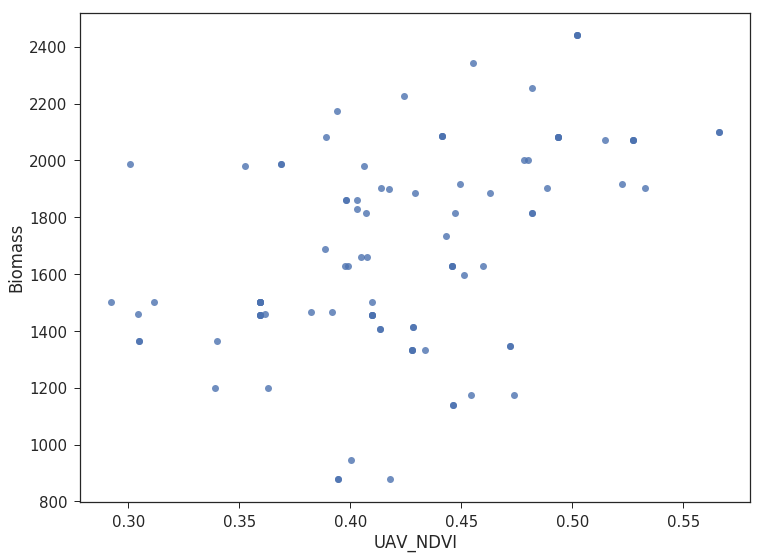

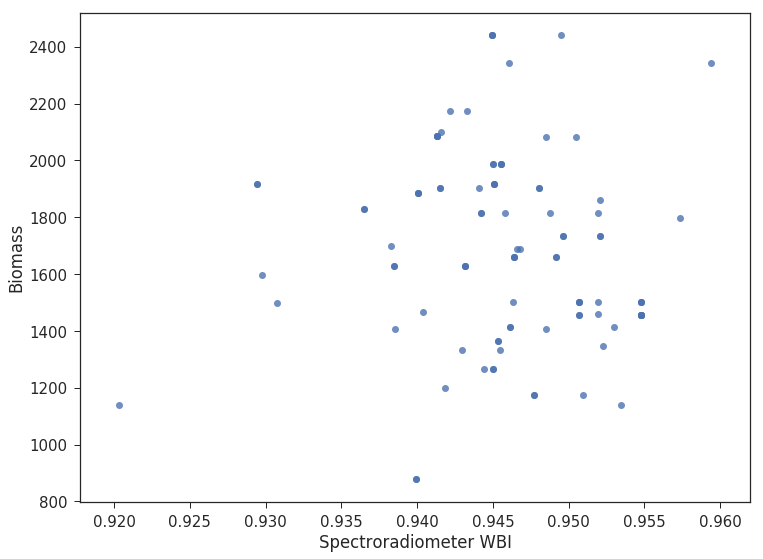

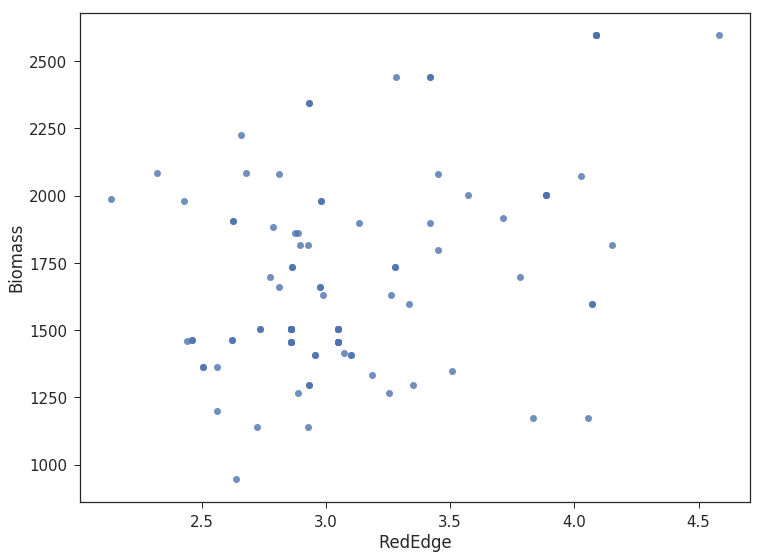

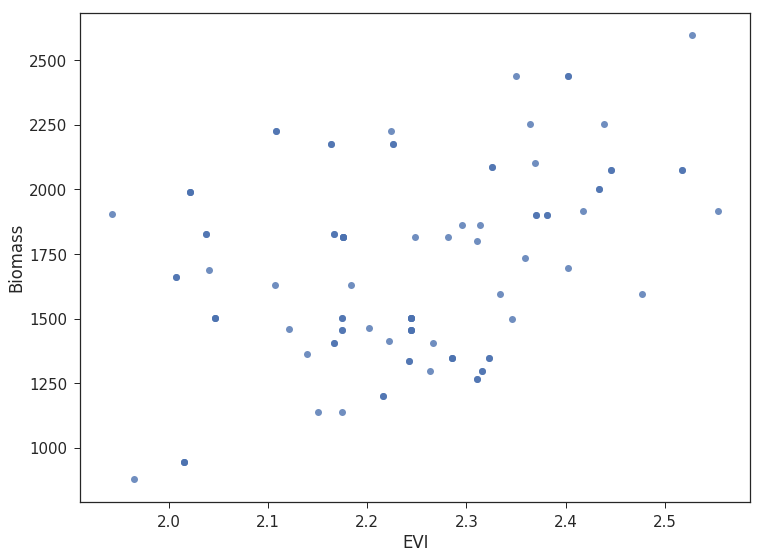

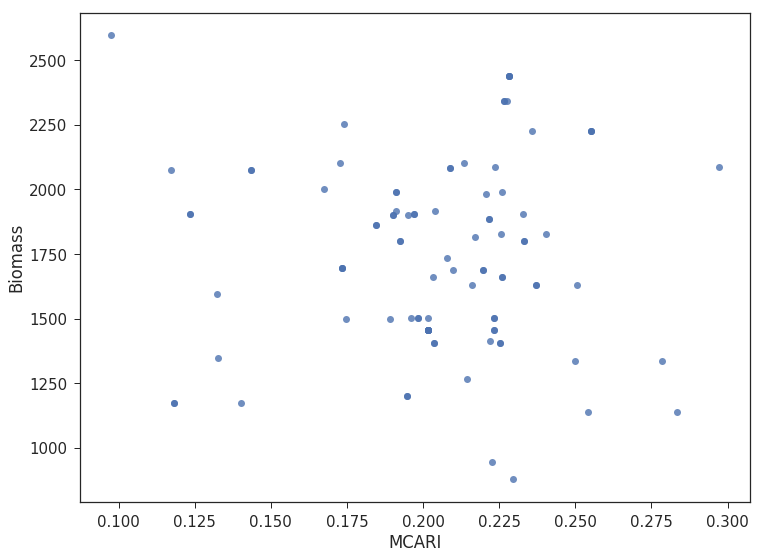

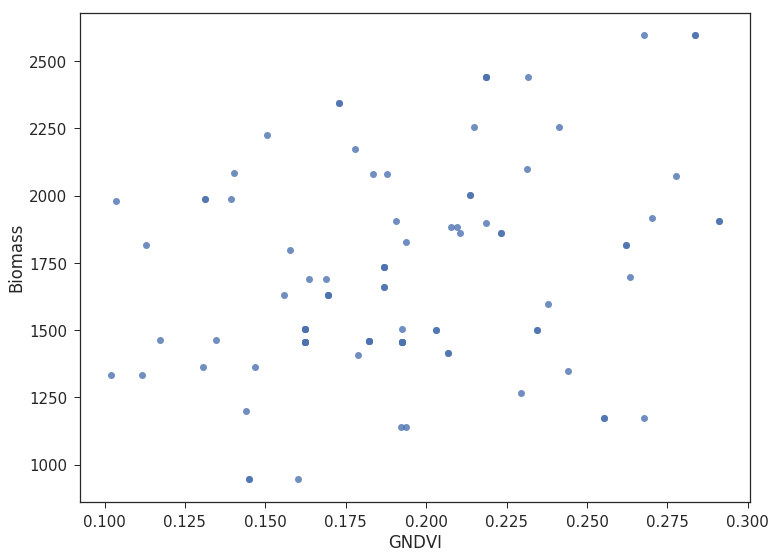

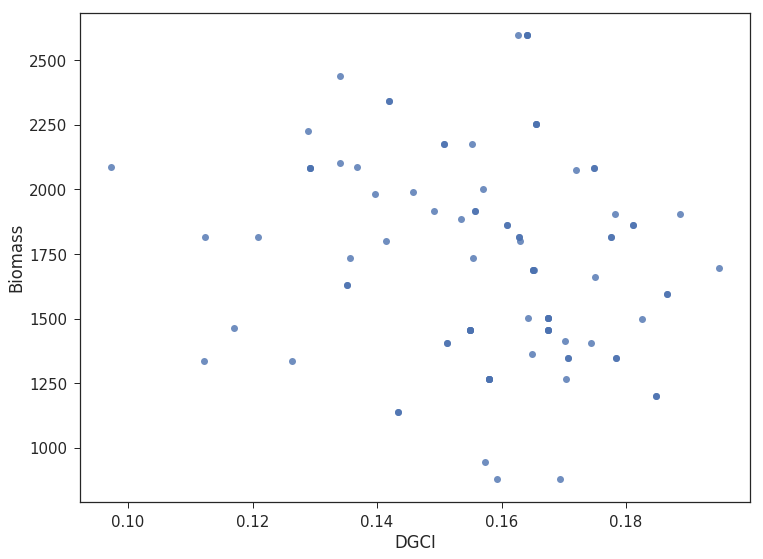

In [63]:
create_scatter(df["UAV_NDVI"], df["Biomass"], "UAV_NDVI", "Biomass")
create_scatter(df["WBI"], df["Biomass"], "Spectroradiometer WBI", "Biomass")
create_scatter(df["RedEdge"], df["Biomass"], "RedEdge", "Biomass")
create_scatter(df["EVI"], df["Biomass"], "EVI", "Biomass")
create_scatter(df["MCARI"], df["Biomass"], "MCARI", "Biomass")
create_scatter(df["GNDVI"], df["Biomass"], "GNDVI", "Biomass")
create_scatter(df["DGCI"], df["Biomass"], "DGCI", "Biomass")